In [84]:
import numpy as np
import torch
from collections import deque
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
import copy

l1 = 50
l2 = 64
l4 = 26


model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, kernel_size=5, stride=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(16, 32, kernel_size=5, stride=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2, 2), stride=(2,2)),
    
    torch.nn.Conv2d(32, 16, kernel_size=3, stride=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2, 2), stride=(2,2)),
    
    torch.nn.Conv2d(16, 16, kernel_size=3, stride=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2, 2), stride=(2,2)),

    torch.nn.Conv2d(16, 1, kernel_size=3, stride=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2, 2), stride=(2,2)),

    torch.nn.Flatten(),
    torch.nn.ReLU(),
    torch.nn.Linear(40,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,l4)
)

model2 = copy.deepcopy(model) #A
model2.load_state_dict(model.state_dict()) #B

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.95
epsilon = 1


epochs = 100
losses = []
rewards = []
mem_size = 20000
batch_size = 32
replay = deque(maxlen=mem_size)
sync_freq = 500  #每500次將eval model 複製到target model
choosed_reward = 4

# Target network

In [85]:
# target model

# target model



import os
import time
#delete output file last time
try:
    os.remove("action_reward.txt")    
    os.remove("reward_result_T.txt")
except OSError as e:
    print(e)
else:
    print("File is deleted successfully")
    
try:
    os.remove("action_reward_T.txt")
except OSError as e:
    print(e)
else:
    print("File is deleted successfully")

try:
    os.remove("qval_result_T.txt")
except OSError as e:
    print(e)
else:
    print("File is deleted successfully")

try:
    os.remove("valid_place_T.txt")
except OSError as e:
    print(e)
else:
    print("File is deleted successfully")

try:
    os.remove("time.txt")
except OSError as e:
    print(e)
else:
    print("File is deleted successfully")

try:
    os.remove("show_tree.txt")
except OSError as e:
    print(e)
else:
    print("File is deleted successfully")

try:
    os.remove("show_tree_test.txt")
except OSError as e:
    print(e)
else:
    print("File is deleted successfully")

try:
    os.remove("train_state_D_bin.txt")
except OSError as e:
    print(e)
else:
    print("File is deleted successfully")

#get all slice info
#get all slice info
file = open("C:/slice data/55_slice.txt",'r')
content = file.read()
file.close
slices = content.split('\n')

#training setting



h = 0
#initial state
input_count = 0
shape = (5,10,)
#6*10 bin, 0 = empty, 1 = filled
tree_tensor = torch.zeros(shape)
state1_ = tree_tensor.reshape(1,50) 
time0 = time.time()

j=0         #計算500次內的第幾次
do_clear = 0
tree_count = 0
total_accept = 0
total_area = 0
accept_prob_per_board = []
PE_per_baord = []
deployed_place = []

for i in range(epochs):    
    #clear board and generate a full bin to train
    #generated_string = generate_full_bin()
    #slices = generated_string.split('\n')
    time1 = time.time() 
    with open("time.txt",'a') as f:
      f.write("episode:")
      f.write(str(i))
      f.write("\n")
    do_clear = 0
    tree_tensor = torch.zeros(shape)
    state1_ = tree_tensor.reshape(1,50)
    random.shuffle(slices)
    status = 1
    input_count = 0
    accepted_count = 0
    total_area = 0
    while(status == 1): #1 board
      #set state        
      #new_slice = slices[(i%800)*12 + input_count].split()
      new_slice = slices[input_count].split()
      width = new_slice[0]
      height = new_slice[1]
      width_ = float(width) / 100
      height_ = float(height) / 100
      width = int(width_)
      height = int(height_)

      #input slice
      #deploy
      for index in range(25,50):
        state1_[0,index] = 0
      for y in range(height):
        for x in range(width):
          state1_[0,25+x+5*y] = 1

      input_count += 1
           
      j+=1
      #convert tensor to image to input to CNN
      img = state1_.reshape(10,-1)
      img_big = torch.zeros(200,100)
      for y in range(5):
        for x in range(10):
          if img[x,y] == 1:
            for a in range(20):
              for b in range(20):
                img_big[x*20+a,y*20+b] = 1

      img_big = img_big.expand(1,200,100)
      time2 = time.time()
      with open("time.txt",'a') as f:
        f.write("get state:")
        f.write(str(time2-time1))
        f.write("\n")
      qval = model(img_big.float())
      qval_ = qval.data.numpy()
      time3 = time.time()
      with open("time.txt",'a') as f:
        f.write("CNN_DQN:")
        f.write(str(time3-time2))
        f.write("\n")
      temp_state1_ = state1_
     
      #select action

      if (random.random() < epsilon):
        #R random choose one in valid place
        action_ = np.random.randint(0,25)    
      else:
        #Q:choose max Q
        action_ = np.argmax(qval_)
      
      #check need deploy?  
      if action_ !=25: #25 == no action
        #check unvalid 1.out of range 2.overlap
        check_unvalid = 0
        action_column = action_ % 5
        if width + action_column -1 > 4: #out of right range
          check_unvalid = 1
          
        for y in range(height): #out of top range
          for x in range(width):     
            if action_+x+5*y > 24:
              check_unvalid = 1

        if check_unvalid == 0:
          for y in range(height):
            for x in range(width):
              if state1_[0,action_+x+5*y] == 1:
                check_unvalid = 1

        #deploy
        if check_unvalid != 1:
          accepted_count += 1
          total_accept += 1
          total_area += width * height
          #deploy
          for y in range(height):
            for x in range(width):
              state1_[0,action_+x+5*y] = 1  
          
        reward = 0
        #calculate reward
        if check_unvalid != 1:
          check = 0
          cluster_Q = []
          cluster_Q.append(action_)
          #print(cluster_Q)
          while check < len(cluster_Q):
            if cluster_Q[check] - 1 > -1 and cluster_Q[check] - 1 not in cluster_Q: #left
              if state1_[0,cluster_Q[check] - 1] == 1:
                cluster_Q.append(cluster_Q[check] - 1)
            if cluster_Q[check] + 1 < 25 and cluster_Q[check] + 1 not in cluster_Q: #right
              if state1_[0,cluster_Q[check] + 1] == 1:
                cluster_Q.append(cluster_Q[check] + 1)
            if cluster_Q[check] - 5 > -1 and cluster_Q[check] - 5 not in cluster_Q: #down 
              if state1_[0,cluster_Q[check] - 5] == 1:
                cluster_Q.append(cluster_Q[check] - 5)  
            if cluster_Q[check] + 5 < 25 and cluster_Q[check] + 5 not in cluster_Q: #up
              if state1_[0,cluster_Q[check] + 5] == 1:
                cluster_Q.append(cluster_Q[check] + 5)
            check += 1

          #print(cluster_Q,"size = ",len(cluster_Q))
          min_x = 999
          max_x = -1
          min_y = 999
          max_y = -1
          for check in cluster_Q:
            #print("check:",check)
            this_y = check // 5
            this_x = check % 5
            if this_x < min_x:
              min_x = this_x
            if this_x > max_x:
              max_x = this_x
            if this_y < min_y:
              min_y = this_y
            if this_y > max_y:
              max_y = this_y

          #print("x:",min_x,max_x," y:",min_y,max_y)
          compactness = len(cluster_Q) / ((max_x - min_x + 1) * (max_y - min_y + 1))
          #print(compactness)
          reward = len(cluster_Q)*compactness
        else:
          reward = -5
      else: #action is 25 no action, calculate special reward
        reward_for_25 = []
        for start in range(24):
          if state1_[0,start] == 1:
            check = 0
            cluster_Q = []
            cluster_Q.append(start)
            #print(cluster_Q)
            while check < len(cluster_Q):
              if cluster_Q[check] - 1 > -1 and cluster_Q[check] - 1 not in cluster_Q: #left
                if state1_[0,cluster_Q[check] - 1] == 1:
                  cluster_Q.append(cluster_Q[check] - 1)
              if cluster_Q[check] + 1 < 25 and cluster_Q[check] + 1 not in cluster_Q: #right
                if state1_[0,cluster_Q[check] + 1] == 1:
                  cluster_Q.append(cluster_Q[check] + 1)
              if cluster_Q[check] - 5 > -1 and cluster_Q[check] - 5 not in cluster_Q: #down 
                if state1_[0,cluster_Q[check] - 5] == 1:
                  cluster_Q.append(cluster_Q[check] - 5)  
              if cluster_Q[check] + 5 < 25 and cluster_Q[check] + 5 not in cluster_Q: #up
                if state1_[0,cluster_Q[check] + 5] == 1:
                  cluster_Q.append(cluster_Q[check] + 5)
              check += 1

              #print(cluster_Q,"size = ",len(cluster_Q))
            min_x = 999
            max_x = -1
            min_y = 999
            max_y = -1
            for check in cluster_Q:
              #print("check:",check)
              this_y = check // 5
              this_x = check % 5
              if this_x < min_x:
                min_x = this_x
              if this_x > max_x:
                max_x = this_x
              if this_y < min_y:
                min_y = this_y
              if this_y > max_y:
                max_y = this_y

            #print("x:",min_x,max_x," y:",min_y,max_y)
            compactness = len(cluster_Q) / ((max_x - min_x + 1) * (max_y - min_y + 1))
            reward_for_25.append(len(cluster_Q)*compactness)
        if len(reward_for_25):
          reward =  max(reward_for_25)
        else:
          reward = 0
      time4 = time.time()
      with open("time.txt",'a') as f:
        f.write("choose action, deploy and reward:")
        f.write(str(time4-time3))
        f.write("\n")  
      
      if input_count ==28:
        reward += 2*(total_area / 25)



      #print("reward=",reward)
      rewards.append(reward)


      state2_ = state1_
      state1_ = temp_state1_
      done = True if input_count == 28 else False

      img_state1 = state1_.reshape(10,-1)
      img_state1_big = torch.zeros(200,100)
      for y in range(5):
        for x in range(10):
          if img_state1[x,y] == 1:
            for a in range(20):
              for b in range(20):
                img_state1_big[x*20+a,y*20+b] = 1

      img_state1_big = img_state1_big.expand(1,200,100)

      img_state2 = state2_.reshape(10,-1)
      img_state2_big = torch.zeros(200,100)
      for y in range(5):
        for x in range(10):
          if img_state2[x,y] == 1:
            for a in range(20):
              for b in range(20):
                img_state2_big[x*20+a,y*20+b] = 1

      img_state2_big = img_state2_big.expand(1,200,100)

      exp =  (img_state1_big, action_, reward, img_state2_big,done)
      replay.append(exp) #H
      time5 = time.time()
      with open("time.txt",'a') as f:
        f.write("save to replay:")
        f.write(str(time5-time4))
        f.write("\n")    
        
      if input_count == 28:
        accept_prob_per_board.append(accepted_count/28)
        PE_per_baord.append(total_area / 25)
        status = 0 #one board done, exit while and clear board

      state1_ = state2_
    
    
    if len(replay) > batch_size:
        start_train_time = time.time()
        minibatch = random.sample(replay, batch_size)
        state1_batch = torch.stack([s1 for (s1,a,r,s2,d) in minibatch])
        action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
        reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
        state2_batch = torch.stack([s2 for (s1,a,r,s2,d) in minibatch])
        done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])


        Q1 = model(state1_batch.float()) 
        Q2_action = model(state2_batch.float())
        target_index = torch.max(Q2_action,dim=1)[1]
        with torch.no_grad():
            Q2 = model2(state2_batch.float()) #B
        
        Y = reward_batch + gamma * Q2.gather(dim=1,index=target_index.long().unsqueeze(dim=1)).squeeze()
        X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
        loss = loss_fn(X, Y.detach())
        if i % 100 == 0:
          print(i,"/",epochs, loss.item())
        clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        end_train_time = time.time()
        with open("time.txt",'a') as f:
          f.write("train:")
          f.write(str(end_train_time-start_train_time))
          f.write("\n")    
        if j % sync_freq == 0: #C
            model2.load_state_dict(model.state_dict())
     
    if epsilon > 0.001:
      epsilon -= 2*(1/epochs)
time_finish = time.time()
with open("time.txt",'a') as f:
        f.write("\n\n\ntime for")
        f.write(str(epochs))
        f.write(" : ")
        f.write(str(time_finish-time))
        f.write("\n")
losses = np.array(losses)

#A Set the update frequency for synchronizing the target model parameters to the main DQN
#B Use the target network to get the maiximum Q-value for the next state
#C Copy the main model parameters to the target network

9900 / 10000 0.06554604321718216


In [69]:
#print(rewards)
print(reward_for_25)

[4.0, 4.0, 4.0, 4.0]


In [78]:
torch.save(model.state_dict(), "deeppack_CNN_no_action_good_input28_30k_model.pt")

total accept rate:  0.09197738095238095


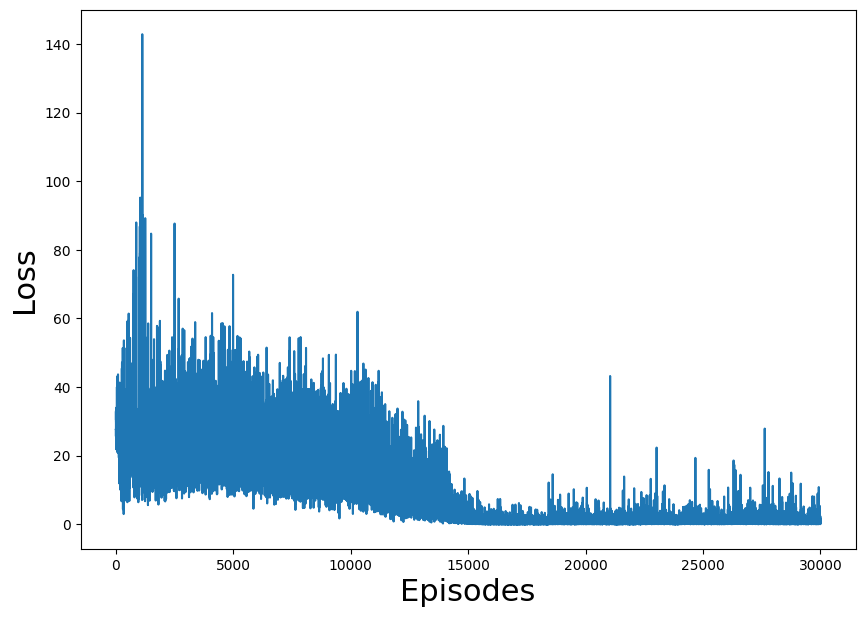

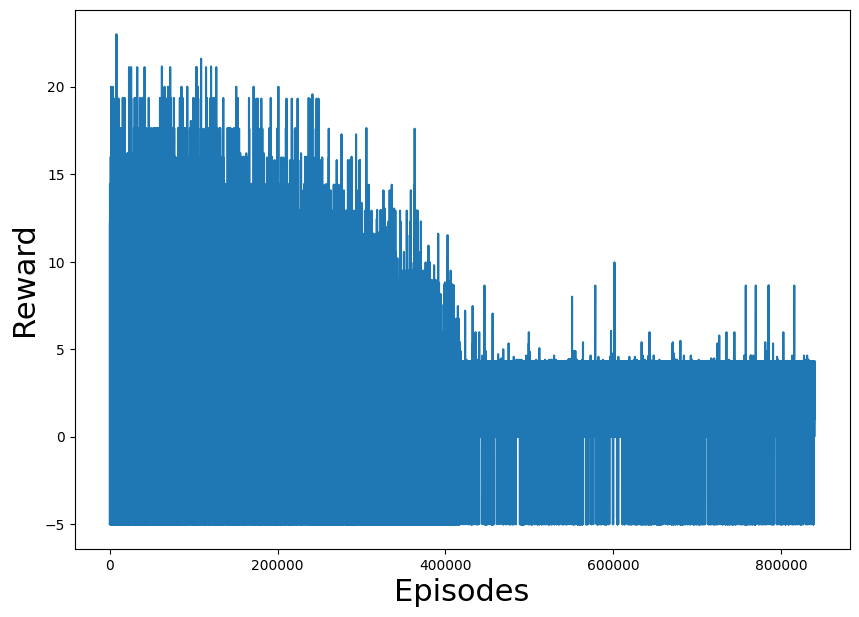

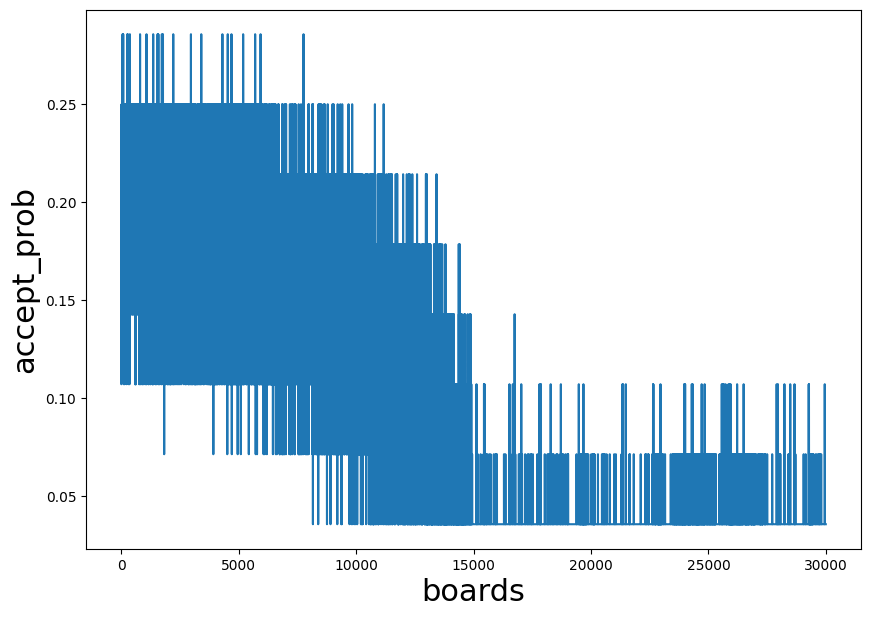

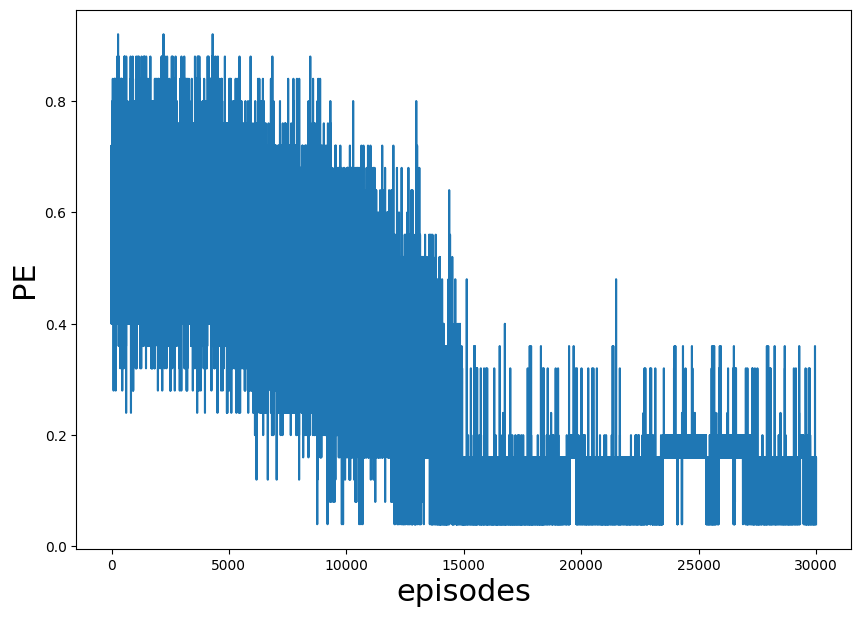

In [79]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Episodes",fontsize=22)
plt.ylabel("Loss",fontsize=22)
plt.savefig("train_loss10.png")

plt.figure(figsize=(10,7))
plt.plot(rewards)
plt.xlabel("Episodes",fontsize=22)
plt.ylabel("Reward",fontsize=22)
plt.savefig("train_reward30.png")

plt.figure(figsize=(10,7))
plt.plot(accept_prob_per_board)
plt.xlabel("boards",fontsize=22)
plt.ylabel("accept_prob",fontsize=22)
plt.savefig("train_accept_prob_per_board30.png")

plt.figure(figsize=(10,7))
plt.plot(PE_per_baord)
plt.xlabel("episodes",fontsize=22)
plt.ylabel("PE",fontsize=22)
plt.savefig("train_PE_per_baord30.png")

print("total accept rate: ",total_accept/(epochs*28))

In [15]:
#load model
import numpy as np
import torch
from collections import deque
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
import copy

l1 = 50
l2 = 64
l4 = 26


model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, kernel_size=5, stride=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(16, 32, kernel_size=5, stride=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2, 2), stride=(2,2)),
    
    torch.nn.Conv2d(32, 16, kernel_size=3, stride=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2, 2), stride=(2,2)),
    
    torch.nn.Conv2d(16, 16, kernel_size=3, stride=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2, 2), stride=(2,2)),

    torch.nn.Conv2d(16, 1, kernel_size=3, stride=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2, 2), stride=(2,2)),

    torch.nn.Flatten(),
    torch.nn.ReLU(),
    torch.nn.Linear(40,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,l4)
)
model.load_state_dict(torch.load("deeppack_CNN_no_action_good_input28_30k_model.pt"))
model.eval()

model2 = copy.deepcopy(model) #A
model2.load_state_dict(model.state_dict()) #B

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.95
epsilon = 0.01

FileNotFoundError: [Errno 2] No such file or directory: 'deeppack_CNN_no_action_good_input28_30k_model.pt'

In [80]:
# target model test
from collections import deque
import random
import os
#delete output file last time
try:
    os.remove("test_result_D.txt")
    os.remove("test_result_D_bin.txt")
    os.remove("test_state_D_bin.txt")

except OSError as e:
    print(e)
else:
    print("File is deleted successfully")

try:
    os.remove("show_tree_test.txt")
except OSError as e:
    print(e)
else:
    print("File is deleted successfully")

#get all slice info
file = open("C:/slice data/55_slice.txt",'r')
content = file.read()
file.close
slices = content.split('\n')

#training setting

epochs = 100
shape = (512,2,)
rewards_test = []

h = 0
#initial state
input_count = 0
shape = (5,10,)
#6*10 bin, 0 = empty, 1 = filled
tree_tensor = torch.zeros(shape)
state1_ = tree_tensor.reshape(1,50)


sync_freq = 500  #每500次將eval model 複製到target model
j=0         #計算500次內的第幾次
do_clear = 0
tree_count = 0
total_accept = 0
total_area = 0
PE_per_baord_test = []
accept_prob_per_board_test = []
test_img = []
for i in range(epochs):    
    #if(i%48 == 0):  #clear board
    random.shuffle(slices)
    do_clear = 0
    shape = (5,10,)
    #6*10 bin, 0 = empty, 1 = filled
    tree_tensor = torch.zeros(shape)
    state1_ = tree_tensor.reshape(1,50)
    status = 1
    input_count = 0
    accepted_count = 0
    total_area = 0
    while(status == 1): #1 board
      #set state        
      new_slice = slices[input_count].split()
      width = new_slice[0]
      height = new_slice[1]
      width_ = float(width) / 100
      height_ = float(height) / 100
      width = int(width_)
      height = int(height_)
      input_count += 1

      #input slice
      #deploy new
      for index in range(25,50):
        state1_[0,index] = 0
      for y in range(height):
        for x in range(width):
          state1_[0,25+x+5*y] = 1        
     
      j+=1

      img = state1_.reshape(10,-1)
      img_big = torch.zeros(200,100)
      for y in range(5):
        for x in range(10):
          if img[x,y] == 1:
            for a in range(20):
              for b in range(20):
                img_big[x*20+a,y*20+b] = 1

      img_big = img_big.expand(1,200,100)
      qval = model(img_big.float())
      qval_ = qval.data.numpy()


      #select action

      if (random.random() < epsilon):
        #R random choose one in valid place
        action_ = np.random.randint(0,25)

      else:
        #Q:choose max Q
        action_ = np.argmax(qval_)
  
      temp_state1_ = state1_

      check_unvalid = 0
      if action_ == 25:
        check_unvalid = 1
        
      action_column = action_ % 5
      if width + action_column -1 > 4: #out of right range
        check_unvalid = 1
      for y in range(height):
        for x in range(width):
          if action_+x+5*y > 24:
            check_unvalid = 1

      if check_unvalid == 0:
        for y in range(height):
          for x in range(width):
            if state1_[0,action_+x+5*y] == 1:
              check_unvalid = 1


      if check_unvalid != 1:
        accepted_count += 1
        total_accept += 1
        total_area += width * height
        #deploy
        for y in range(height):
          for x in range(width):
            state1_[0,action_+x+5*y] = 1  
        
          

        

      #calculate reward
      if check_unvalid != 1:
          check = 0
          cluster_Q = []
          cluster_Q.append(action_)
          print(cluster_Q)
          while check < len(cluster_Q):
            if cluster_Q[check] - 1 > -1 and cluster_Q[check] - 1 not in cluster_Q: #left
              if state1_[0,cluster_Q[check] - 1] == 1:
                cluster_Q.append(cluster_Q[check] - 1)
            if cluster_Q[check] + 1 < 25 and cluster_Q[check] + 1 not in cluster_Q: #right
              if state1_[0,cluster_Q[check] + 1] == 1:
                cluster_Q.append(cluster_Q[check] + 1)
            if cluster_Q[check] - 5 > -1 and cluster_Q[check] - 5 not in cluster_Q: #down 
              if state1_[0,cluster_Q[check] - 5] == 1:
                cluster_Q.append(cluster_Q[check] - 5)  
            if cluster_Q[check] + 5 < 25 and cluster_Q[check] + 5 not in cluster_Q: #up
              if state1_[0,cluster_Q[check] + 5] == 1:
                cluster_Q.append(cluster_Q[check] + 5)
            check += 1

          print(cluster_Q,"size = ",len(cluster_Q))
          min_x = 999
          max_x = -1
          min_y = 999
          max_y = -1
          for check in cluster_Q:
            print("check:",check)
            this_y = check // 5
            this_x = check % 5
            if this_x < min_x:
              min_x = this_x
            if this_x > max_x:
              max_x = this_x
            if this_y < min_y:
              min_y = this_y
            if this_y > max_y:
              max_y = this_y

          print("x:",min_x,max_x," y:",min_y,max_y)
          compactness = len(cluster_Q) / ((max_x - min_x + 1) * (max_y - min_y + 1))
          print(compactness)
          reward = len(cluster_Q)*compactness
      else:
        reward = -5
        
      if action_ == 25:
        reward_for_25 = []
        for start in range(24):
          if state1_[0,start] == 1:
            check = 0
            cluster_Q = []
            cluster_Q.append(start)
            #print(cluster_Q)
            while check < len(cluster_Q):
              if cluster_Q[check] - 1 > -1 and cluster_Q[check] - 1 not in cluster_Q: #left
                if state1_[0,cluster_Q[check] - 1] == 1:
                  cluster_Q.append(cluster_Q[check] - 1)
              if cluster_Q[check] + 1 < 25 and cluster_Q[check] + 1 not in cluster_Q: #right
                if state1_[0,cluster_Q[check] + 1] == 1:
                  cluster_Q.append(cluster_Q[check] + 1)
              if cluster_Q[check] - 5 > -1 and cluster_Q[check] - 5 not in cluster_Q: #down 
                if state1_[0,cluster_Q[check] - 5] == 1:
                  cluster_Q.append(cluster_Q[check] - 5)  
              if cluster_Q[check] + 5 < 25 and cluster_Q[check] + 5 not in cluster_Q: #up
                if state1_[0,cluster_Q[check] + 5] == 1:
                  cluster_Q.append(cluster_Q[check] + 5)
              check += 1

              #print(cluster_Q,"size = ",len(cluster_Q))
            min_x = 999
            max_x = -1
            min_y = 999
            max_y = -1
            for check in cluster_Q:
              #print("check:",check)
              this_y = check // 5
              this_x = check % 5
              if this_x < min_x:
                min_x = this_x
              if this_x > max_x:
                max_x = this_x
              if this_y < min_y:
                min_y = this_y
              if this_y > max_y:
                max_y = this_y

            #print("x:",min_x,max_x," y:",min_y,max_y)
            compactness = len(cluster_Q) / ((max_x - min_x + 1) * (max_y - min_y + 1))
            reward_for_25.append(len(cluster_Q)*compactness)
        if len(reward_for_25):
          reward =  max(reward_for_25)
        else:
          reward = 0


      print("reward=",reward)
      rewards_test.append(reward)
    
      state2_ = state1_
      state1_ = temp_state1_
    
        
      if input_count == 28:
        accept_prob_per_board_test.append(accepted_count/28)
        PE_per_baord_test.append(total_area / 25)
        
        finish_img = state1_.reshape(10,-1)
        finish_img_big = torch.zeros(100,100)
        for y in range(5):
          for x in range(5):
            if finish_img[x,y] == 1:
              for a in range(20):
                for b in range(20):
                  finish_img_big[x*20+a,y*20+b] = 1

        #finish_img_big = finish_img_big.expand(1,200,100)
        test_img.append(finish_img_big)
        
        status = 0 #one board done, exit while and clear board


      

      state1_ = state2_
      print("episode:",i)
      clear_output(wait=True)
    if epsilon > 0.1:
      epsilon -= (1/epochs)
        


#A Set the update frequency for synchronizing the target model parameters to the main DQN
#B Use the target network to get the maiximum Q-value for the next state
#C Copy the main model parameters to the target network
print("total accept rate: ",total_accept/(100*28))


total accept rate:  0.036071428571428574


total accept rate:  0.036071428571428574


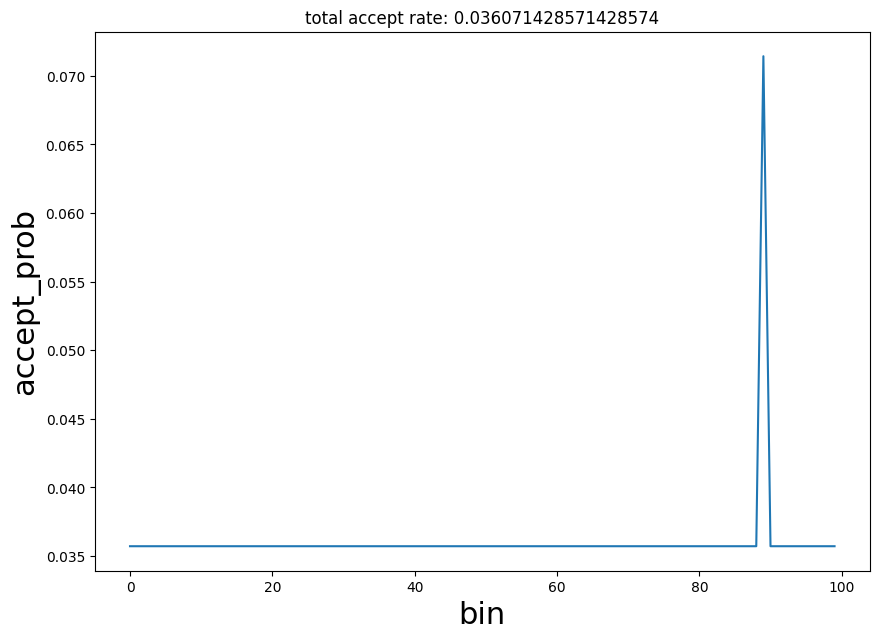

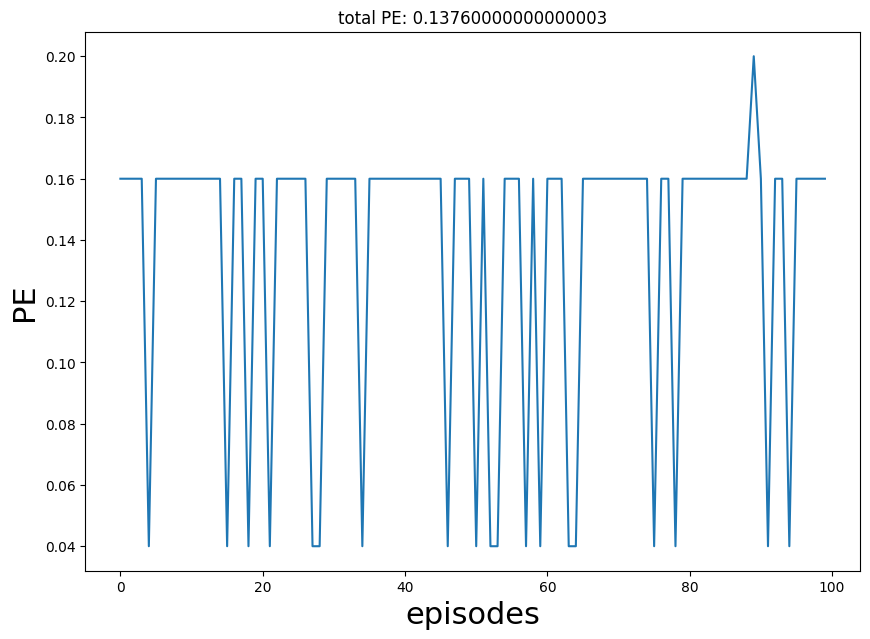

In [81]:
total_accept_rate_string = "total accept rate: " + str(total_accept/(100*28))
total_PE_string = "total PE: " + str(sum(PE_per_baord_test)/len(PE_per_baord_test))
plt.figure(figsize=(10,7))
plt.title(total_accept_rate_string)
plt.plot(accept_prob_per_board_test)
plt.xlabel("bin",fontsize=22)
plt.ylabel("accept_prob",fontsize=22)
plt.savefig("accept_prob_per_board_test10.png")

plt.figure(figsize=(10,7))
plt.title(total_PE_string)
plt.plot(PE_per_baord_test)
plt.xlabel("episodes",fontsize=22)
plt.ylabel("PE",fontsize=22)
plt.savefig("PE_per_baord_test10.png")

print("total accept rate: ",total_accept/(100*28))

#for now in range(100):
#  print("time window",now+1,":",round(accept_prob_per_board[now],3),end = ',')
#  if now % 10 == 9:
#    print("\n")

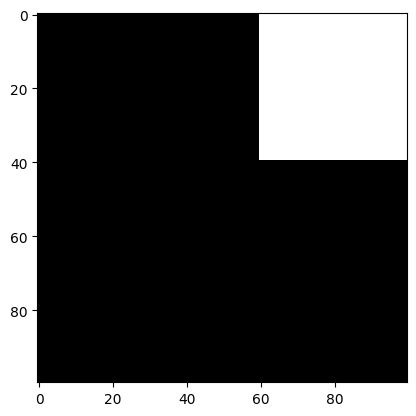

In [83]:
for item in range(len(test_img)):
    plt.imshow(test_img[item],cmap='gray')
    path =   "result img30/" + str(item) + ".png"
    plt.savefig(path)